<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#skip-gram-model" data-toc-modified-id="skip-gram-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>skip-gram model</a></span><ul class="toc-item"><li><span><a href="#corpus" data-toc-modified-id="corpus-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>corpus</a></span></li><li><span><a href="#preprocessing" data-toc-modified-id="preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>preprocessing</a></span></li></ul></li><li><span><a href="#PyTorch-Word2Vec-Network" data-toc-modified-id="PyTorch-Word2Vec-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PyTorch Word2Vec Network</a></span><ul class="toc-item"><li><span><a href="#preprocessing" data-toc-modified-id="preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>preprocessing</a></span></li><li><span><a href="#establish-network" data-toc-modified-id="establish-network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>establish network</a></span></li><li><span><a href="#save-model" data-toc-modified-id="save-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>save model</a></span></li><li><span><a href="#extract-word-embedding" data-toc-modified-id="extract-word-embedding-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>extract word embedding</a></span></li><li><span><a href="#Visualizaion" data-toc-modified-id="Visualizaion-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Visualizaion</a></span></li></ul></li></ul></div>

# skip-gram model


In [1]:
import numpy as np
import torch
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

## corpus

In [2]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'queen is a woman',
    'king is a man',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',   
]

## preprocessing


In [3]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)


In [4]:
tokenized_corpus

[['he', 'is', 'a', 'king'],
 ['she', 'is', 'a', 'queen'],
 ['he', 'is', 'a', 'man'],
 ['she', 'is', 'a', 'woman'],
 ['queen', 'is', 'a', 'woman'],
 ['king', 'is', 'a', 'man'],
 ['warsaw', 'is', 'poland', 'capital'],
 ['berlin', 'is', 'germany', 'capital'],
 ['paris', 'is', 'france', 'capital']]

In [5]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

vocabulary_size


15

In [6]:
vocabulary

['he',
 'is',
 'a',
 'king',
 'she',
 'queen',
 'man',
 'woman',
 'warsaw',
 'poland',
 'capital',
 'berlin',
 'germany',
 'paris',
 'france']

In [7]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array
# idx_pairs-----(center_word, context_word)

In [8]:
idx_pairs

array([[ 0,  1],
       [ 0,  2],
       [ 1,  0],
       [ 1,  2],
       [ 1,  3],
       [ 2,  0],
       [ 2,  1],
       [ 2,  3],
       [ 3,  1],
       [ 3,  2],
       [ 4,  1],
       [ 4,  2],
       [ 1,  4],
       [ 1,  2],
       [ 1,  5],
       [ 2,  4],
       [ 2,  1],
       [ 2,  5],
       [ 5,  1],
       [ 5,  2],
       [ 0,  1],
       [ 0,  2],
       [ 1,  0],
       [ 1,  2],
       [ 1,  6],
       [ 2,  0],
       [ 2,  1],
       [ 2,  6],
       [ 6,  1],
       [ 6,  2],
       [ 4,  1],
       [ 4,  2],
       [ 1,  4],
       [ 1,  2],
       [ 1,  7],
       [ 2,  4],
       [ 2,  1],
       [ 2,  7],
       [ 7,  1],
       [ 7,  2],
       [ 5,  1],
       [ 5,  2],
       [ 1,  5],
       [ 1,  2],
       [ 1,  7],
       [ 2,  5],
       [ 2,  1],
       [ 2,  7],
       [ 7,  1],
       [ 7,  2],
       [ 3,  1],
       [ 3,  2],
       [ 1,  3],
       [ 1,  2],
       [ 1,  6],
       [ 2,  3],
       [ 2,  1],
       [ 2,  6],
       [ 6,  1

In [9]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [10]:
embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 101
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)


    
        log_softmax = F.log_softmax(z2, dim=0)
#         print(log_softmax.view(1,-1).shape)
#         print(log_softmax.shape)
#         print(y_true)
        

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)

        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 5.365805343786875
Loss at epo 10: 4.265196937074264
Loss at epo 20: 3.7574497762653563
Loss at epo 30: 3.427095933755239
Loss at epo 40: 3.183838502400451
Loss at epo 50: 2.992399157087008
Loss at epo 60: 2.835820076531834
Loss at epo 70: 2.7055015221238135
Loss at epo 80: 2.596596153742737
Loss at epo 90: 2.505732663638062
Loss at epo 100: 2.429963717692428


In [11]:
print(W1.shape)
print(W2.T.shape)
W = W1+W2.T
print((W/2).shape)

torch.Size([5, 15])
torch.Size([5, 15])
torch.Size([5, 15])


# PyTorch Word2Vec Network

## preprocessing

In [24]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital', 
]

In [25]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

In [26]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

vocabulary_size

15

In [27]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [28]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [29]:
word2idx

{'he': 0,
 'is': 1,
 'a': 2,
 'king': 3,
 'she': 4,
 'queen': 5,
 'man': 6,
 'woman': 7,
 'warsaw': 8,
 'poland': 9,
 'capital': 10,
 'berlin': 11,
 'germany': 12,
 'paris': 13,
 'france': 14}

## establish network

In [56]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.functional as F
import torch.nn.functional as F


In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


dim = 5
vocabulary_size = vocabulary_size

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,dim,vocabulary_size):
        super(NeuralNetwork, self).__init__()
        self.dim = dim
        self.vocabulary_size=vocabulary_size
        self.linear_w2v = nn.Sequential(
            nn.Linear(self.vocabulary_size , self.dim),
            nn.Sigmoid(),
            #nn.ReLU(),
            nn.Linear(self.dim, self.vocabulary_size),
        )

    def forward(self, x):
#         x = self.flatten(x)
        res = self.linear_w2v(x)
        #res = nn.Softmax(dim=0)(res)
        res = F.log_softmax(res, dim=0)
        return res

model = NeuralNetwork(5,vocabulary_size = vocabulary_size).to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_w2v): Sequential(
    (0): Linear(in_features=15, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=15, bias=True)
  )
)


In [84]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3)




In [85]:
def train(idx_pairs, model, loss_fn, optimizer,num_epochs):
    model.train()
    for epo in range(num_epochs):
        for data, target in idx_pairs:
            x = get_input_layer(data)

            y_true = Variable(torch.from_numpy(np.array([target])).long())
            
            x, y_true = x.to(device), y_true.to(device)
#             print(y_true.shape)
            
            pred = model(x)
#             print(pred.view(1,-1).shape)
            loss = loss_fn(pred.view(1,-1), y_true)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epo % 1000 == 0:    
            print( f"loss: {loss:>7f}  [{epo:>5d}/{num_epochs:>5d}]")
       
    
            

In [86]:
num_epochs = 10000
train(idx_pairs, model, loss_fn, optimizer,num_epochs)
# test(test_dataloader, model, loss_fn)
print("Done!")


loss: 2.643618  [    0/10000]
loss: 2.806059  [ 1000/10000]
loss: 2.074090  [ 2000/10000]
loss: 1.897772  [ 3000/10000]
loss: 1.829331  [ 4000/10000]
loss: 1.832941  [ 5000/10000]
loss: 1.870591  [ 6000/10000]
loss: 1.901261  [ 7000/10000]
loss: 1.903641  [ 8000/10000]
loss: 1.885684  [ 9000/10000]
Done!


## save model 

In [76]:
torch.save(model.state_dict(), "w2v_model.pth")
print("Saved PyTorch Model State to model.pth")
model

Saved PyTorch Model State to model.pth


NeuralNetwork(
  (linear_w2v): Sequential(
    (0): Linear(in_features=15, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=15, bias=True)
  )
)

In [38]:
model = NeuralNetwork(dim,vocabulary_size)
model.load_state_dict(torch.load("w2v_model.pth"))


RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	size mismatch for linear_w2v.0.weight: copying a param with shape torch.Size([5, 15]) from checkpoint, the shape in current model is torch.Size([8, 15]).
	size mismatch for linear_w2v.0.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for linear_w2v.2.weight: copying a param with shape torch.Size([15, 5]) from checkpoint, the shape in current model is torch.Size([15, 8]).

## extract word embedding

In [77]:
res = []
for name, param in model.named_parameters():
    print(name)
    print('--')
    print(param)
    print('\n')
    if 'weight' in name :
        res.append(param)

linear_w2v.0.weight
--
Parameter containing:
tensor([[ 1.2015e+00, -1.0389e+00, -2.3440e+00,  1.1638e+00,  1.2037e+00,
          1.1665e+00,  1.1683e+00,  1.1705e+00, -2.3201e+00,  2.1557e+00,
         -2.0076e+00, -1.4280e+00,  2.9285e-01, -2.3417e+00,  4.4944e+00],
        [ 1.2386e-01, -9.1122e-02, -2.4335e-01, -2.4151e-01, -9.0420e-02,
          8.9497e-02,  2.1107e-01, -5.8691e-02, -1.4327e-01, -1.6976e-01,
         -2.5615e-01,  2.4340e-02, -1.8688e-01, -2.2939e-01,  2.4763e-02],
        [-2.2950e-01,  2.5879e+00, -2.3201e-01, -2.2780e-01, -2.3282e-01,
         -2.2865e-01, -2.2926e-01, -2.3299e-01, -2.0410e-01, -2.2839e-01,
         -2.3066e-01, -2.2990e-01, -2.2427e-01, -2.2456e-01, -2.2040e-01],
        [-9.1927e-02,  1.4393e-01, -7.0724e-03,  1.7079e-02, -1.4363e-01,
          8.6440e-02,  3.0028e-02,  4.8143e-02,  3.4159e-03, -1.1509e-01,
         -2.9805e-02, -1.8536e-01,  1.4871e-01,  7.1334e-02, -6.7604e-02],
        [-9.0249e-01,  8.2928e-02,  1.4584e+00, -9.2534e-01, -9

In [78]:
ress= ((res[0].T)).data + ((res[1])).data
embedding = (ress/2)
print(embedding.shape)
embedding

torch.Size([15, 5])


tensor([[-0.2883,  0.1216,  0.2237,  0.0705,  0.3801],
        [ 0.3541, -0.0819, -0.6920, -0.0030,  0.0103],
        [ 0.6461, -0.2998,  0.2763, -0.2229, -0.8091],
        [-0.0900, -0.3059,  0.0681, -0.1335,  0.2593],
        [-0.3944,  0.0689,  0.2748, -0.1350,  0.3865],
        [-0.1730,  0.0045,  0.1137,  0.2163,  0.2731],
        [-0.2312, -0.0789,  0.1498, -0.0620,  0.2910],
        [-0.2893, -0.1274,  0.1639, -0.0698,  0.2689],
        [-0.0741, -0.2543, -0.1263, -0.1003, -0.0721],
        [-0.1981, -0.2549,  0.4620, -0.1695,  0.3691],
        [ 0.1556,  0.0781, -0.0500, -0.1424, -0.1518],
        [-0.2850,  0.0191,  0.0451, -0.2312,  0.2579],
        [ 0.7165, -0.2443, -0.1047, -0.1063,  0.4139],
        [ 0.3533,  0.0822,  0.0492, -0.0952, -0.3586],
        [ 1.4647, -0.1718, -0.1412,  0.1055,  0.4539]])

In [79]:
embedding_np = embedding.numpy()
embedding_np

array([[-0.28826517,  0.12164679,  0.22372392,  0.07050588,  0.38010073],
       [ 0.35405755, -0.08190916, -0.6919917 , -0.00300702,  0.01030795],
       [ 0.64607024, -0.2998314 ,  0.27626485, -0.22294661, -0.80913925],
       [-0.09001738, -0.30591652,  0.06811734, -0.13348739,  0.25930002],
       [-0.39443386,  0.06893147,  0.27483577, -0.13503258,  0.38651553],
       [-0.17295939,  0.00449817,  0.11369327,  0.21628049,  0.2731137 ],
       [-0.2312125 , -0.07888495,  0.14975473, -0.06203181,  0.2909721 ],
       [-0.28927362, -0.12738416,  0.16386008, -0.06982535,  0.26886347],
       [-0.07405913, -0.2543118 , -0.12634334, -0.10032488, -0.07211134],
       [-0.19814897, -0.2549076 ,  0.4619699 , -0.16948594,  0.3691212 ],
       [ 0.15559053,  0.0780872 , -0.04998878, -0.14241827, -0.1518383 ],
       [-0.28499806,  0.019077  ,  0.04508601, -0.23123997,  0.25785702],
       [ 0.71647865, -0.24429075, -0.10465132, -0.10629469,  0.41394794],
       [ 0.35334992,  0.08221771,  0.0

## Visualizaion

In [80]:
target_lable = np.array(list(word2idx.keys()))
target_lable

array(['he', 'is', 'a', 'king', 'she', 'queen', 'man', 'woman', 'warsaw',
       'poland', 'capital', 'berlin', 'germany', 'paris', 'france'],
      dtype='<U7')

In [81]:
color = np.array(list(word2idx.values()))
color

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

(15, 5)
(15,)


/opt/anaconda3/envs/python-run/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/python-run/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


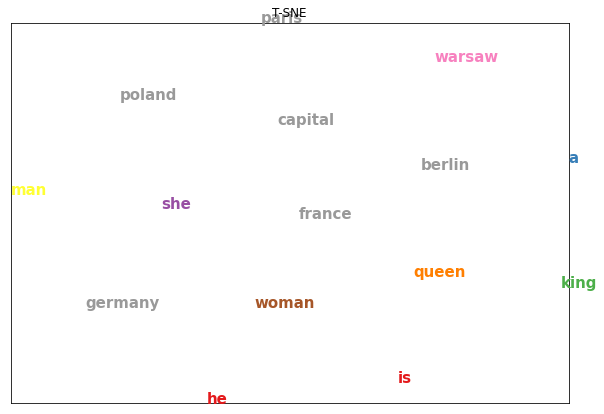

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import seaborn as sns




class FeatureVisualize(object):
    '''
    Visualize features by TSNE
    '''

    def __init__(self, features, labels,color):
        '''
        features: (m,n)
        labels: (m,)
        '''
        self.features = features
        self.labels = labels
        self.color = color

    def plot_tsne(self, save_eps=False):
        ''' Plot TSNE figure. Set save_eps=True if you want to save a .eps file.
        '''
        fig, axs = plt.subplots(figsize=(10,7))
        tsne = TSNE(n_components=2, init='pca', random_state=0)
        features = tsne.fit_transform(self.features)
        x_min, x_max = np.min(features, 0), np.max(features, 0)
        data = (features - x_min) / (x_max - x_min)
        del features
        for i in range(data.shape[0]):
            plt.text(data[i, 0], data[i, 1], str(self.labels[i]),
                     color=plt.cm.Set1(self.color[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 15})
        plt.xticks([])
        plt.yticks([])
        plt.title('T-SNE')
        if save_eps:
            plt.savefig('tsne.eps', dpi=600, format='eps')
        plt.grid(True)

        plt.show()


if __name__ == '__main__':
    digits = datasets.load_digits(n_class=5)
    features, labels = embedding_np,target_lable #digits.data, digits.target
    print(features.shape)
    print(labels.shape)
    vis = FeatureVisualize(features, labels,color)
    vis.plot_tsne(save_eps=True)